# Prediction Pipeline: LGBM with fully random train-val splitting

In [1]:
# local imports
from model_tools import PredictorData
from tree_models import LGBM_Predictor
from utils import Utils

In [2]:
config = Utils.read_config_for_env(config_path='../config/config.yml')
pred_data = PredictorData(
    config,
    refresh_monthly=False,
    refresh_ts_features=False,
    clean_strategy='olrem_for_all',
    split_strategy='random',
    # split_strategy='last_months_val',
    # split_strategy='months',
    num_lag_mon=3,
    val_ratio=0.2)

Loading data.. Done.
Fixing data schemas.. Done.
Loading /home/onur/WORK/DS/repos/shop_sales_prediction/data/all_ts.parquet


## Basic LightGBM model

In [3]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error as mse 

In [4]:
lgbm_predictor = LGBM_Predictor(
        pred_data=pred_data)

In [5]:
lgbm_predictor.pred_data = lgbm_predictor.split_transform(
        lgbm_predictor.pred_data,
        lgbm_predictor.transformer)

Splitting train-val
Fit-transforming X_train
Transforming X_val


In [6]:
# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(
    lgbm_predictor.pred_data.X_train,
    label=lgbm_predictor.pred_data.y_train,
    feature_name=lgbm_predictor.pred_data.transformed_feature_names) 
# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
val_data = lgb.Dataset(
    lgbm_predictor.pred_data.X_val,
    label=lgbm_predictor.pred_data.y_val,
    feature_name=lgbm_predictor.pred_data.transformed_feature_names,
    reference=train_data) 
# Define a dictionary of parameters for configuring the LightGBM regression model. 

In [7]:
params = { 
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
}
callback_early_stopping = lgb.early_stopping(5)
num_round = 100
model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[val_data],
    callbacks=[callback_early_stopping, lgb.log_evaluation()],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.343530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 31924800, number of used features: 18
[LightGBM] [Info] Start training from score 0.072491
[1]	valid_0's l2: 0.568718
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.522739
[3]	valid_0's l2: 0.485461
[4]	valid_0's l2: 0.455478
[5]	valid_0's l2: 0.430156
[6]	valid_0's l2: 0.409909
[7]	valid_0's l2: 0.393389
[8]	valid_0's l2: 0.379721
[9]	valid_0's l2: 0.368454
[10]	valid_0's l2: 0.358867
[11]	valid_0's l2: 0.352833
[12]	valid_0's l2: 0.346103
[13]	valid_0's l2: 0.340146
[14]	valid_0's l2: 0.33524
[15]	valid_0's l2: 0.331098
[16]	valid_0's l2: 0.327492
[17]	valid_0's l2: 0.324639
[18]	valid_0's l2: 0.32199
[19]	valid_0's l2: 0.319542
[20]	valid

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

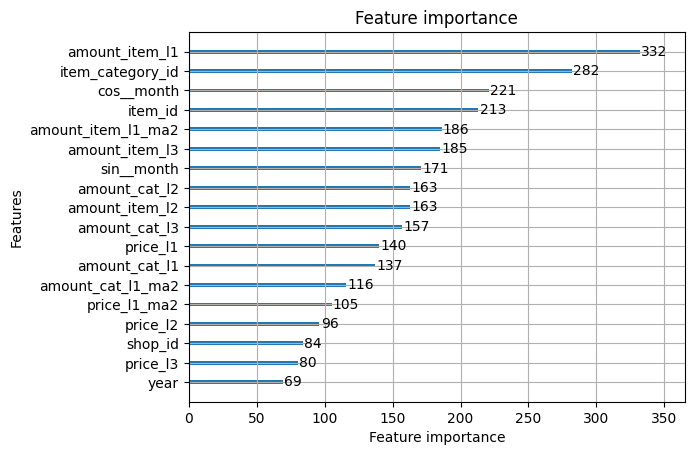

In [8]:
lgb.plot_importance(model)

In [9]:
# Make predictions on the training and validation data. 
pred_train = model.predict(lgbm_predictor.pred_data.X_train)
pred_val = model.predict(lgbm_predictor.pred_data.X_val)

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions. 
print("Training RMSE: ", np.sqrt(mse(lgbm_predictor.pred_data.y_train, pred_train)))
print("Validation RMSE: ", np.sqrt(mse(lgbm_predictor.pred_data.y_val, pred_val)))

Training RMSE:  0.5281012916325473
Validation RMSE:  0.5378728401908854


## LightGBM tuned with AutoML

In [10]:
from flaml import AutoML
import numpy as np
import matplotlib.pyplot as plt

In [11]:
automl = AutoML()
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": "mse",  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ["lgbm"],  # list of ML learners; we tune lightgbm in this example
    "task": "regression",  # task type
    "log_file_name": "store_sales_lgbm.log"  # flaml log file
    # "seed": 42,  # random seed
}
automl.fit(
    X_train=lgbm_predictor.pred_data.X_train,
    y_train=lgbm_predictor.pred_data.y_train,
    **settings)

[flaml.automl.logger: 06-09 18:36:22] {1680} INFO - task = regression
[flaml.automl.logger: 06-09 18:36:22] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-09 18:37:35] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 06-09 18:37:35] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 06-09 18:37:35] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-09 18:37:35] {2345} INFO - Estimated sufficient time budget=7032750s. Estimated necessary time budget=7033s.
[flaml.automl.logger: 06-09 18:37:35] {2392} INFO -  at 72.9s,	estimator lgbm's best error=0.6121,	best estimator lgbm's best error=0.6121
[flaml.automl.logger: 06-09 18:37:35] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-09 18:37:35] {2392} INFO -  at 73.2s,	estimator lgbm's best error=0.6121,	best estimator lgbm's best error=0.6121
[flaml.automl.logger: 06-09 18:37:35] {2219} INFO - iteration 2, current learner lgbm
[fla

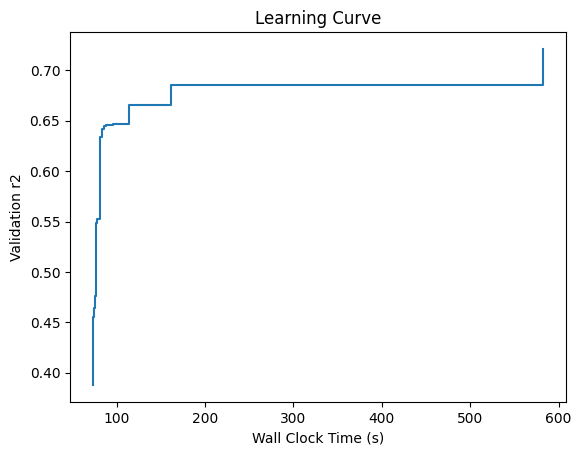

In [12]:
from flaml.automl.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=settings['log_file_name'], time_budget=600)
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

In [13]:
print("Best hyperparmeter config:", automl.best_config)
print("Best r2 on validation data: {0:.4g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 188, 'num_leaves': 34, 'min_child_samples': 2, 'learning_rate': 0.20607567441549396, 'log_max_bin': 8, 'colsample_bytree': 0.7298650648227573, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.9445363699513247}
Best r2 on validation data: 0.7211
Training duration of best run: 333.6 s
LGBMRegressor(colsample_bytree=0.7298650648227573,
              learning_rate=0.20607567441549396, max_bin=255,
              min_child_samples=2, n_estimators=1, n_jobs=-1, num_leaves=34,
              reg_alpha=0.0009765625, reg_lambda=0.9445363699513247,
              verbose=-1)


In [14]:
# Make predictions on the training and validation data. 
pred_train = automl.predict(lgbm_predictor.pred_data.X_train)
pred_val = automl.predict(lgbm_predictor.pred_data.X_val)

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions. 
print("Training RMSE: ", np.sqrt(mse(lgbm_predictor.pred_data.y_train, pred_train)))
print("Validation RMSE: ", np.sqrt(mse(lgbm_predictor.pred_data.y_val, pred_val)))

Training RMSE:  0.4912160707071531
Validation RMSE:  0.5235348863054484


<BarContainer object of 18 artists>

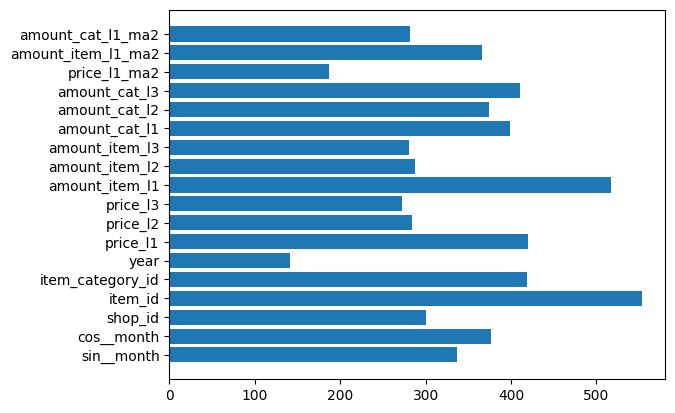

In [15]:
# plt.barh(automl.feature_names_in_, automl.feature_importances_)
plt.barh(lgbm_predictor.pred_data.transformed_feature_names, automl.feature_importances_)